<a href="https://colab.research.google.com/github/rizwanyusuf017/deep_learning/blob/main/3DatasaetBatik.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download laoderhizwanyusuf/dataset-batik-dayak-batik-betawi-dan-batik-bali
!mkdir batik


In [ ]:
!unzip /content/dataset-batik-dayak-batik-betawi-dan-batik-bali.zip -d /content/batik

In [12]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from keras.optimizers import Adam
from pathlib import Path
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split

In [13]:
dataset_path = Path(r'/content/batik/3 Dataset Batik')
file_path = list(dataset_path.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [14]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)
df = pd.concat([file_path, labels], axis=1)
df.columns = ['image', 'label']
df.head()

,image,label
0,/content/batik/3 Dataset Batik/Batik Dayak/50.jpg,Batik Dayak
1,/content/batik/3 Dataset Batik/Batik Dayak/40.jpg,Batik Dayak
2,/content/batik/3 Dataset Batik/Batik Dayak/58.jpg,Batik Dayak
3,/content/batik/3 Dataset Batik/Batik Dayak/8.jpg,Batik Dayak
4,/content/batik/3 Dataset Batik/Batik Dayak/47.jpg,Batik Dayak


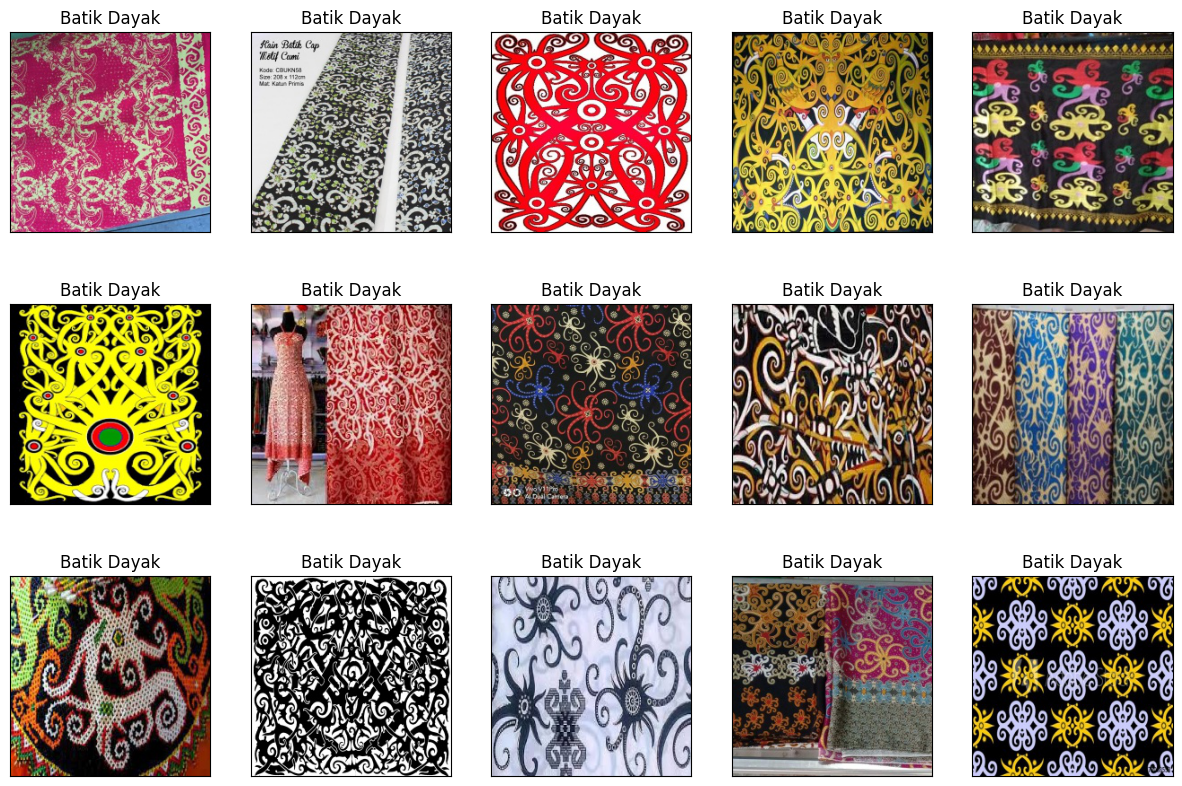

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [11]:
df.label.value_counts()

Batik Bali      79
Batik Dayak     70
Batik Betawi    70
Name: label, dtype: int64

In [19]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Batik Bali      79
Batik Dayak     70
Batik Betawi    70
Name: label, dtype: int64

In [20]:
x_train, x_test = train_test_split(df, test_size=0.3,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [21]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (122, 2)
Shape of test data (66, 2)
Shape of validation data (31, 2)


In [24]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
train = image_data_generator.flow_from_dataframe(dataframe=x_train, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical', shuffle=False)
val = image_data_generator.flow_from_dataframe(dataframe=x_val, x_col='image', y_col='label', target_size=(200,200), color_mode='rgb', class_mode='categorical',shuffle=False)
 

Found 122 validated image filenames belonging to 3 classes.
Found 66 validated image filenames belonging to 3 classes.
Found 31 validated image filenames belonging to 3 classes.


In [32]:
input_shape = (200, 200, 3)

In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 198, 198, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 99, 99, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 97, 97, 64)        36928     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 48, 48, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 46, 46, 32)        18464     
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 23, 23, 32)      

In [46]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=4)
history = model.fit(train, batch_size= 64, validation_data=val, epochs=80, callbacks=callback)

Epoch 1/80
4/4 [==============================] - 21s 5s/step - loss: 1.0908 - accuracy: 0.3607 - val_loss: 1.0787 - val_accuracy: 0.5161
Epoch 2/80
4/4 [==============================] - 17s 5s/step - loss: 1.0064 - accuracy: 0.4918 - val_loss: 1.0743 - val_accuracy: 0.4516
Epoch 3/80
4/4 [==============================] - 17s 5s/step - loss: 1.0533 - accuracy: 0.5000 - val_loss: 1.0622 - val_accuracy: 0.4516
Epoch 4/80
4/4 [==============================] - 18s 4s/step - loss: 0.9868 - accuracy: 0.4918 - val_loss: 1.0665 - val_accuracy: 0.5806
Epoch 5/80
4/4 [==============================] - 18s 4s/step - loss: 0.9764 - accuracy: 0.5656 - val_loss: 1.0105 - val_accuracy: 0.6129
Epoch 6/80
4/4 [==============================] - 17s 5s/step - loss: 0.9481 - accuracy: 0.5328 - val_loss: 1.0145 - val_accuracy: 0.5484
Epoch 7/80
4/4 [==============================] - 17s 5s/step - loss: 0.9479 - accuracy: 0.5410 - val_loss: 1.0932 - val_accuracy: 0.4839
Epoch 8/80
4/4 [==================

In [47]:
model.save('model-1.h5')

In [48]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

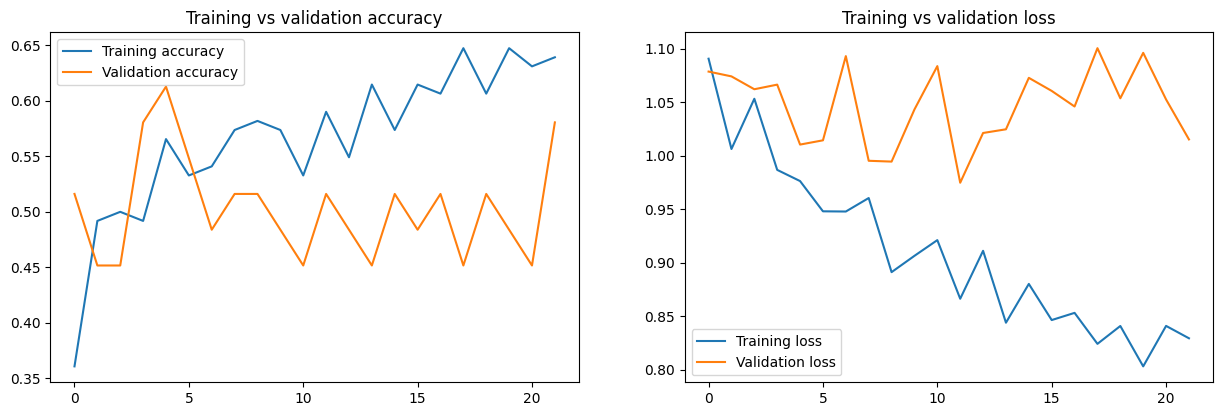

In [49]:
plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")
plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")
plt.show()

In [50]:
pred = model.predict(test)

3/3 [==============================] - 3s 504ms/step


In [51]:
pred = np.argmax(pred, axis=1)

In [52]:
labels = train.class_indices

In [53]:
labels

{'Batik Bali': 0, 'Batik Betawi': 1, 'Batik Dayak': 2}

In [54]:
labels = dict((v,k) for k, v in labels.items())

In [55]:
labels

{0: 'Batik Bali', 1: 'Batik Betawi', 2: 'Batik Dayak'}

In [56]:
y_pred = [labels[k] for k in pred]

In [57]:
print(classification_report(x_test.label, y_pred))

              precision    recall  f1-score   support

  Batik Bali       0.59      0.68      0.63        25
Batik Betawi       0.47      0.35      0.40        20
 Batik Dayak       0.50      0.52      0.51        21

    accuracy                           0.53        66
   macro avg       0.52      0.52      0.51        66
weighted avg       0.52      0.53      0.52        66



In [58]:
print(confusion_matrix(x_test.label, y_pred))

[[17  4  4]
 [ 6  7  7]
 [ 6  4 11]]


In [59]:
test_accuracy = model.evaluate(test)[1]

3/3 [==============================] - 3s 466ms/step - loss: 1.0537 - accuracy: 0.5000
